# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free).


### Problem Statement

The main goals I am trying to achieve are:
- Build a machine learning model for each kind of offer that predicts whether they will complete the offer.
- Build an all-in-one model that predicts whether or not someone will respond to an offer.

Using the data provided, I will try to achieve my goals using several classification supervised machine learning models, feeding in the data from three different offer types.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
#load library
import pandas as pd
import numpy as np
import math
from datetime import datetime
import json

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data exploring and wrangling

In [2]:
# take a look at the portfolio data
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [5]:
# split channels into separate columns
channel = ['web', 'email', 'mobile', 'social']
channels = portfolio.channels.apply(lambda row:pd.Series([1 if i in row else 0 for i in channel]))

portfolio[channel] = channels

# drop the channels column
portfolio.drop(columns='channels', inplace=True)

In [6]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [7]:
# find how many unique id we have
portfolio.id.nunique()

10

In [8]:
# see the offer types
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [9]:
# create dummy for the offer types
portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type)).drop(columns='offer_type')

In [10]:
# convert the duration from days to hours
portfolio.duration = portfolio.duration.apply( lambda x : x*24 )

In [11]:
portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


Then, I will work on the profile dataset.

In [12]:
# a quick look at the dataset
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
# see if we have duplicated id
profile.id.duplicated().sum()

0

In [14]:
# a quick look at the dataset
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


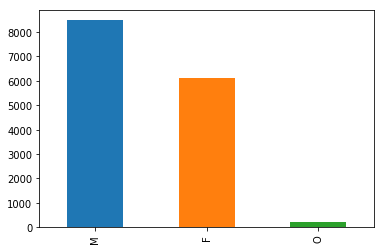

In [15]:
#plot gender column
profile.gender.value_counts().plot(kind = 'bar');

In [16]:
# create dummy for gender
profile = profile.join(pd.get_dummies(profile.gender)).drop(columns='gender')

In [17]:
# clean the became member date and turn into days of membership
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
now = datetime(2020,12,1)
profile['membership'] = profile.member_date.apply(lambda x : (now - x).days)
profile.drop('became_member_on', axis = 1, inplace = True)

In [18]:
# find the null values in the dataset
profile.isnull().sum()

age               0
id                0
income         2175
F                 0
M                 0
O                 0
member_date       0
membership        0
dtype: int64

In [19]:
# find how many users are using defult age
profile.query('age == "118"').shape

(2175, 8)

In [20]:
# see whether users with defult age also having nulls
profile.query('age == "118"').isnull().sum()

age               0
id                0
income         2175
F                 0
M                 0
O                 0
member_date       0
membership        0
dtype: int64

In [21]:
profile.query('age == "118"').shape[0]/profile.shape[0]

0.12794117647058822

In [22]:
# drop the users with null value
profile.dropna(inplace= True)

We have nulls in gender and income columns. And seems those using defult age are also those having null values. I will drop those data here, since they are less than 13%.
Then, I would take a look at the distribution of the data.

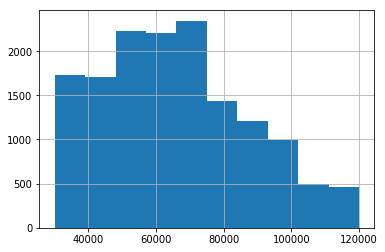

In [23]:
# plot the hist for income 
profile.income.hist();

I will split income into 4 groups for easier analysis.

In [24]:
# split income into 4 groups
profile.loc[profile['income'] < 50000, 'income_group']= 'group_1'
profile.loc[(profile['income'] >= 50000) & (profile['income'] < 70000), 'income_group'] = 'group_2'
profile.loc[(profile['income'] >= 70000) & (profile['income'] < 90000), 'income_group'] = 'group_3'
profile.loc[profile['income'] > 90000, 'income_group'] = 'group_4'

# drop income column
profile.drop(columns='income', axis = 1, inplace= True)

In [25]:
profile.head()

,age,id,F,M,O,member_date,membership,income_group
1,55,0610b486422d4921ae7d2bf64640c50b,1,0,0,2017-07-15,1235,group_4
3,75,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,2017-05-09,1302,group_4
5,68,e2127556f4f64592b11af22de27a7932,0,1,0,2018-04-26,950,group_3
8,65,389bc3fa690240e798340f5a15918d5c,0,1,0,2018-02-09,1026,group_2
12,58,2eeac8d8feae4a8cad5a6af0499a211d,0,1,0,2017-11-11,1116,group_2


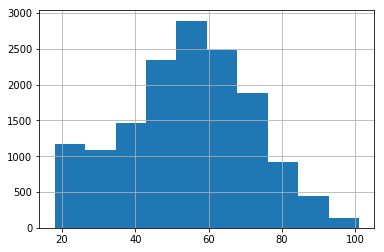

In [26]:
# plot the hist for age 
profile.age.hist();

Seems like the members majorly are 40-70 years old. I will split age into 3 groups for easier analysis.

In [27]:
# split age into 3 groups
profile.loc[profile['age'] < 35, 'age_group']= 'group_1'
profile.loc[(profile['age'] >= 35) & (profile['age'] < 60), 'age_group'] = 'group_2'
profile.loc[profile['age'] >= 60 , 'age_group'] = 'group_3'

# drop age column
profile.drop(columns='age', axis = 1, inplace= True)

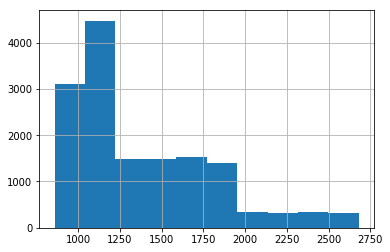

In [28]:
# distribution of membership
profile.membership.hist();

I will also split members into 3 groups based on how long they have joined.

In [29]:
# split members into 3 groups
profile.loc[profile['membership'] < 1250, 'membership_group']= 'group_1'
profile.loc[(profile['membership'] >= 1250) & (profile['membership'] < 2000), 'membership_group'] = 'group_2'
profile.loc[profile['membership'] >= 2000 , 'membership_group'] = 'group_3'

# drop memmership column
profile.drop(columns={'membership', 'member_date'}, axis = 1, inplace= True)

After splitting the group, I will create dummies for each column.

In [30]:
# create dummy for the offer types
profile = profile.join(pd.get_dummies(profile.age_group, prefix= 'age')).drop(columns='age_group', axis = 1)
profile = profile.join(pd.get_dummies(profile.income_group, prefix = 'income')).drop(columns='income_group', axis = 1)
profile = profile.join(pd.get_dummies(profile.membership_group, prefix = 'membership')).drop(columns='membership_group', axis = 1)

In [31]:
profile.head()

,id,F,M,O,age_group_1,age_group_2,age_group_3,income_group_1,income_group_2,income_group_3,income_group_4,membership_group_1,membership_group_2,membership_group_3
1,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,1,0,0,0,0,1,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,1,0,0,0,1,0,1,0
5,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,1,0,0,1,0,1,0,0
8,389bc3fa690240e798340f5a15918d5c,0,1,0,0,0,1,0,1,0,0,1,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0,1,0,0,1,0,0,1,0,0,1,0,0


Now, I will start workiing on the transcript dataset.

In [32]:
# quick look into transcript data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [33]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


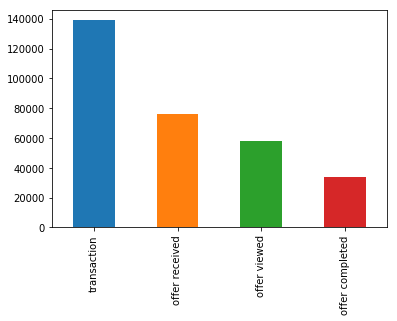

In [34]:
# plot the event column
transcript.event.value_counts().plot(kind = 'bar');

In [35]:
transcript[transcript['event'] == 'offer received'].shape

(76277, 4)

From the plot, we can tell that more than 80% of offers are viewed. And the transactions are way more than the offers sent.

To have a better view of the dataset, I will expand the value column.

In [36]:
# expand the value column
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


Since there are two offer id, I will clean them up.

In [37]:
#clean up the offer id, offer_id columns
transcript['offer_id']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

# drop offer_id, offer id columns
transcript.drop(['offer id', 'value'],axis=1,inplace=True)

transcript.head()

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


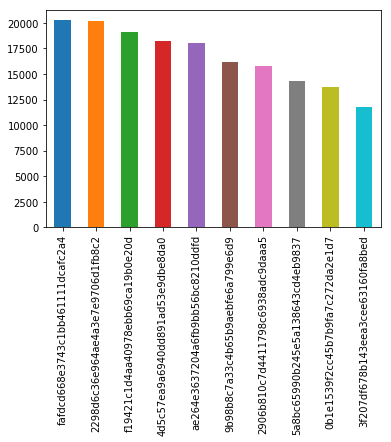

In [38]:
transcript.offer_id.value_counts().plot(kind = 'bar');

First, I want to focus on the informational offers. Since we don't know whether the offer is complete, I will mark the offer as effective if there is any transaction in the duration after viewing the offer. 

In [39]:
# sort data by person and time
transcript=transcript.sort_values(['person','time'])
transcript.head()

,event,person,time,amount,offer_id,reward
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN


In [40]:
# filter dataset for transactions that occur after an offer is viewed
transacted=transcript[['time','offer_id','person','event']][(transcript['event']=='transaction')|(transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
transacted.head()

,person,offer_id,time,event
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,offer viewed
89291,0009655768c64bdeb2e877511632db8f,NaN,228,transaction
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,offer viewed
168412,0009655768c64bdeb2e877511632db8f,NaN,414,transaction
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed


In [41]:
# forward fill offer ids by person
transacted['offer_id']=transacted['offer_id'].ffill()
transacted.head()

,person,offer_id,time,event
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,offer viewed
89291,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,228,transaction
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,offer viewed
168412,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,414,transaction
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed


In [42]:
# merge back to the whole dataset
transcript=transcript.merge(transacted,how='left',on=['person','time','event'])
transcript.head()

,event,person,time,amount,offer_id_x,reward,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed


In [43]:
#clean up multiple offer id columns into one column
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])

transcript.drop(columns={'offer_id_x','offer_id_y'}, axis = 1, inplace = True);

transcript.head()

,event,person,time,amount,reward,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed


In [44]:
# merge transcript with portfolio
transcript=transcript.merge(portfolio,how='left',left_on='offer_id', right_on = 'id')
transcript.head()

,event,person,time,amount,reward_x,offer_id,difficulty,duration,id,reward_y,web,email,mobile,social,bogo,discount,informational
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1


In [45]:
# drop the not using columns and rename the column
transcript.drop(columns= {'reward_x', 'id'}, axis = 1, inplace = True)
transcript.rename(columns={'reward_y':'reward'},inplace=True)
transcript.head()

,event,person,time,amount,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0,0,1
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0,0,1
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0,0,1
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,0,96,0,1,1,1,0,0,0,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,0,96,0,1,1,1,0,0,0,1


Now, I mark all the transaction with the offer id. Then, I will flag out the users complete the transaction in time after viewing the offer, which are the group that we want to focus.

In [46]:
# split the data into bogo, info, discount
transcript_info = transcript.query('informational == "1"')
transcript_bogo = transcript.query('bogo == "1"')
transcript_dis = transcript.query('discount == "1"')

In [47]:
transcript_bogo.shape

(133805, 15)

Now, I will use diff function to flag those effective offer.

In [48]:
#sort transactions to ensure all events occurring by person and offer
transcript_info=transcript_info.sort_values(['person','time','offer_id'])
transcript_info.head()

,event,person,time,amount,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0,0,1
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0,0,1
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0,0,1
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,0,96,0,1,1,1,0,0,0,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,0,96,0,1,1,1,0,0,0,1


In [49]:
#get difference in time for informational offers
transcript_info['time_diff']=transcript_info[(transcript_info['event']=='offer viewed') | (transcript_info['event']=='transaction')].groupby(['person','offer_id'])['time'].diff()
transcript_info.head()

,event,person,time,amount,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational,time_diff
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0,0,1,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0,0,1,NaN
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0,0,1,36.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,0,96,0,1,1,1,0,0,0,1,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,0,96,0,1,1,1,0,0,0,1,NaN


In [50]:
#flag valid events if within duration
transcript_info.loc[transcript_info['time_diff']<=transcript_info['duration'],'valid_transaction']=1

#fill any missing values with 0 flag
transcript_info['valid_transaction'].fillna(value=0, inplace= True)

#
info_offers_complete = transcript_info.groupby(['person', 'offer_id'], as_index= False)['valid_transaction'].sum()

#
info_offers_complete['valid_complete'] = info_offers_complete['valid_transaction'].apply(lambda x : 1 if x > 1 else x)

In [51]:
# get the offer receive
info_received_clean = transcript_info.query('event == "offer received"').drop_duplicates(['person','offer_id'])

In [52]:
info_clean = info_received_clean.merge(info_offers_complete[['person', 'offer_id', 'valid_complete']], on = ['person', 'offer_id'])

info_clean.drop(columns= {'event', 'valid_transaction', 'time_diff', 'bogo', 'discount', 'informational', 'amount', 'time'}, inplace= True)

info_clean.head()

,person,offer_id,difficulty,duration,reward,web,email,mobile,social,valid_complete
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,1.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,96,0,1,1,1,0,1.0
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,96,0,1,1,1,0,0.0
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,0.0
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,1,1,1,1.0


For bogo and discount, I will mark those completed after viewing as effective.

In [53]:
def valid_complete_offer(df):
    '''
    INPUT: 
    - df: dataframe needs to be processed
    
    OUTPUT:
    - df: dataframe with a column that validate(1/0) the offers completed after viewed 
        
    '''
    # make a copy for offer received and offer that viewed and completed
    complete = df[(df['event'] == 'offer completed') | (df['event'] == 'offer viewed')].copy()
    receive = df[df['event'] == 'offer received'].copy()
    
    # use diff to calculate the difference between view and complete
    complete['time_diff'] = complete.groupby(['person','offer_id'])['time'].diff()
    
    # flag out the effective complete and fill the nan with 0
    complete.loc[complete['time_diff'] <= complete['duration'],'valid_complete']=1
    complete.valid_complete.fillna(0, inplace= True)
    
    # sum up the completed offer and 
    complete_sum = complete[complete['event'] == 'offer completed'].groupby(['person', 'offer_id'], as_index= False)['valid_complete'].sum()
    complete_sum['valid_complete'] = complete_sum['valid_complete'].apply(lambda x : 1 if x > 1 else x)
    
    # drop the duplicates
    receive.drop_duplicates(subset = ['person','offer_id'], inplace= True)
    
    clean = receive.merge(complete_sum[['person', 'offer_id', 'valid_complete']], on = ['person', 'offer_id'])

    clean.drop(columns= {'event', 'amount', 'time', 'bogo', 'discount', 'informational'}, inplace = True)
    
    return clean

In [54]:
bogo_clean = valid_complete_offer(transcript_bogo)
discount_clean = valid_complete_offer(transcript_dis)

In [55]:
info_clean.valid_complete.mean()

0.5037546439016678

In [56]:
discount_clean.valid_complete.mean()

0.734440911155818

In [57]:
bogo_clean.valid_complete.mean()

0.73901523515124756

In [58]:
def merge_offer_profile(df):
    '''
    INPUT:
    - df: dataframe with offers info
    OUTPUT:
    - df: dataframe that merge the offer info with customer info
    
    '''
    df = pd.merge(df, profile, how = 'left', on = 'person')
    
    return df


In [59]:
profile.rename(columns={'id':'person'}, inplace = True)

In [60]:
bogo_clean = merge_offer_profile(bogo_clean)
info_clean = merge_offer_profile(info_clean)
discount_clean = merge_offer_profile(discount_clean)

Since there are some users with defult will cause null in the dataset, I will drop those data here.

In [61]:
bogo_clean.dropna(inplace= True)
info_clean.dropna(inplace= True)
discount_clean.dropna(inplace= True)

Now we have all the dataset cleaned, it's time to find out the group of users respond best to offer.

### Data Modeling

In [62]:
def get_train_test(df, features, target):
    '''
    INPUT :
    - df : dataframe that needs to be split   
    - features : feature columns
    - target : target column
    
    OUTPUT :
    - X_train, X_test, y_train, y_test with features scaling on both datasets.
    
    '''
    features = df[features]
    target = df[target]
        
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

    # fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    # scale test data
    X_test=scaler.transform(X_test)
    
    return X_train,X_test,y_train, y_test

In [63]:
def model_pipeline(ML_model, X_train, y_train, X_test, y_test):
    '''
    INPUTS:
       - ML_model: the machine learning model to be trained and predicted on
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
       
    OUTPUTS:
       - print out the mean squared error and accuracy of the ML model
    '''
    results = {}
    
    # fit the learner to the training data and get training time
    model = ML_model.fit(X_train, y_train.values.ravel())
    
    # get predictions on the test set, and predictions on training set
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    
    #add training accuracy to results
    results['training_score']= model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']= model.score(X_test,y_test)
    
    print("{} trained on {} samples.".format(ML_model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    
    return results

For each type of offer, I will test several machine learning model.

First, I will be testing with the informational offers.

In [64]:
# check feature columns and target column
info_clean.columns

Index(['person', 'offer_id', 'difficulty', 'duration', 'reward', 'web',
       'email', 'mobile', 'social', 'valid_complete', 'F', 'M', 'O',
       'age_group_1', 'age_group_2', 'age_group_3', 'income_group_1',
       'income_group_2', 'income_group_3', 'income_group_4',
       'membership_group_1', 'membership_group_2', 'membership_group_3'],
      dtype='object')

In [65]:
# set the feature and target variables
features = ['difficulty', 'duration', 'reward', 'web', 'email', 'mobile', 'social', 'F', 'M', 'O', 'age_group_1', 'age_group_2', 'age_group_3', 'income_group_1', 'income_group_2', 'income_group_3', 'income_group_4',
       'membership_group_1', 'membership_group_2', 'membership_group_3']
target = ['valid_complete']

In [66]:
# get the training and testing set
X_train,X_test,y_train, y_test = get_train_test(info_clean, features, target)

In [67]:
info_log_result = model_pipeline(LogisticRegression(), X_train, y_train, X_test, y_test)

LogisticRegression trained on 8832 samples.
MSE_train: 0.3620
MSE_test: 0.3554
Training accuracy:0.6380
Test accuracy:0.6446
             precision    recall  f1-score   support

        0.0     0.6402    0.6145    0.6271      1074
        1.0     0.6486    0.6731    0.6606      1135

avg / total     0.6445    0.6446    0.6443      2209



In [68]:
info_DT_result = model_pipeline(DecisionTreeClassifier(random_state= 0), X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 8832 samples.
MSE_train: 0.3390
MSE_test: 0.3395
Training accuracy:0.6610
Test accuracy:0.6605
             precision    recall  f1-score   support

        0.0     0.6506    0.6518    0.6512      1074
        1.0     0.6699    0.6687    0.6693      1135

avg / total     0.6605    0.6605    0.6605      2209



In [69]:
info_RF_result = model_pipeline(RandomForestClassifier(random_state= 0), X_train, y_train, X_test, y_test) 

RandomForestClassifier trained on 8832 samples.
MSE_train: 0.3394
MSE_test: 0.3377
Training accuracy:0.6606
Test accuracy:0.6623
             precision    recall  f1-score   support

        0.0     0.6574    0.6378    0.6474      1074
        1.0     0.6667    0.6855    0.6759      1135

avg / total     0.6622    0.6623    0.6621      2209



In [70]:
info_ADA_result = model_pipeline(AdaBoostClassifier(random_state= 0), X_train, y_train, X_test, y_test) 

AdaBoostClassifier trained on 8832 samples.
MSE_train: 0.3619
MSE_test: 0.3545
Training accuracy:0.6381
Test accuracy:0.6455
             precision    recall  f1-score   support

        0.0     0.6414    0.6145    0.6277      1074
        1.0     0.6492    0.6749    0.6618      1135

avg / total     0.6454    0.6455    0.6452      2209



In [71]:
info_SVM_result = model_pipeline(SVC(random_state= 0), X_train, y_train, X_test, y_test) 

SVC trained on 8832 samples.
MSE_train: 0.3431
MSE_test: 0.3418
Training accuracy:0.6569
Test accuracy:0.6582
             precision    recall  f1-score   support

        0.0     0.6441    0.6639    0.6538      1074
        1.0     0.6724    0.6529    0.6625      1135

avg / total     0.6586    0.6582    0.6583      2209



From the results, I chose random forest classifier to do gridsearch for better accuracy.

In [72]:
# set parameters for grid search 
parameter= {'max_features': ['auto', 'sqrt'],
            'max_depth' : [None, 5, 10, 15, 20],
            'n_estimators': [10, 20, 25, 30, 40, 50],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 2, 10, 20],
            }
grid_search = GridSearchCV(RandomForestClassifier(random_state = 0), parameter)
grid_search.fit(X_train, y_train.values.ravel())
# get the best parameters
best_params = grid_search.best_params_
print("best parameters:", best_params)

best parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 50}


In [73]:
info_RF_model = RandomForestClassifier(max_depth= 10, 
                               max_features= 'auto', 
                               min_samples_leaf= 20, 
                               min_samples_split= 2, 
                               n_estimators= 50, 
                               random_state= 0)

info_RF_grid_result = model_pipeline(info_RF_model, X_train, y_train, X_test, y_test) 

RandomForestClassifier trained on 8832 samples.
MSE_train: 0.3450
MSE_test: 0.3418
Training accuracy:0.6550
Test accuracy:0.6582
             precision    recall  f1-score   support

        0.0     0.6473    0.6527    0.6500      1074
        1.0     0.6687    0.6634    0.6661      1135

avg / total     0.6583    0.6582    0.6582      2209



After the grid search, I got a model with lower accuracy but higher precision and f1-score.

Then, I will test the machine learning models with BOGO offers.

In [74]:
# get the training and testing set
X_train, X_test, y_train, y_test = get_train_test(bogo_clean, features, target)

In [75]:
bogo_log_result = model_pipeline(LogisticRegression(), X_train, y_train, X_test, y_test)

LogisticRegression trained on 10560 samples.
MSE_train: 0.2499
MSE_test: 0.2655
Training accuracy:0.7501
Test accuracy:0.7345
             precision    recall  f1-score   support

        0.0     0.5489    0.1022    0.1724       714
        1.0     0.7443    0.9688    0.8419      1926

avg / total     0.6915    0.7345    0.6608      2640



In [76]:
bogo_DT_result = model_pipeline(DecisionTreeClassifier(random_state= 0), X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 10560 samples.
MSE_train: 0.2369
MSE_test: 0.2708
Training accuracy:0.7631
Test accuracy:0.7292
             precision    recall  f1-score   support

        0.0     0.4982    0.1989    0.2843       714
        1.0     0.7571    0.9258    0.8330      1926

avg / total     0.6871    0.7292    0.6846      2640



In [77]:
bogo_RF_result = model_pipeline(RandomForestClassifier(random_state= 0), X_train, y_train, X_test, y_test) 

RandomForestClassifier trained on 10560 samples.
MSE_train: 0.2374
MSE_test: 0.2705
Training accuracy:0.7626
Test accuracy:0.7295
             precision    recall  f1-score   support

        0.0     0.5000    0.1877    0.2729       714
        1.0     0.7555    0.9304    0.8339      1926

avg / total     0.6864    0.7295    0.6822      2640



In [78]:
bogo_ADA_result = model_pipeline(AdaBoostClassifier(random_state= 0), X_train, y_train, X_test, y_test) 

AdaBoostClassifier trained on 10560 samples.
MSE_train: 0.2516
MSE_test: 0.2663
Training accuracy:0.7484
Test accuracy:0.7337
             precision    recall  f1-score   support

        0.0     0.5487    0.0868    0.1499       714
        1.0     0.7420    0.9735    0.8421      1926

avg / total     0.6897    0.7337    0.6549      2640



In [79]:
bogo_SVM_result = model_pipeline(SVC(random_state= 0), X_train, y_train, X_test, y_test) 

SVC trained on 10560 samples.
MSE_train: 0.2405
MSE_test: 0.2606
Training accuracy:0.7595
Test accuracy:0.7394
             precision    recall  f1-score   support

        0.0     0.5586    0.1737    0.2650       714
        1.0     0.7560    0.9491    0.8416      1926

avg / total     0.7026    0.7394    0.6857      2640



In [80]:
# set parameters for grid search 
parameter= {'C': [0.1, 1, 10], 
            'gamma': [1, 0.1, 0.01],
            }
grid_search = GridSearchCV(SVC(random_state = 0), parameter)
grid_search.fit(X_train, y_train.values.ravel())

# get the best parameters
best_params = grid_search.best_params_
print("best parameters:", best_params)

best parameters: {'C': 10, 'gamma': 0.01}


In [81]:
bogo_SVM = SVC(C= 10, gamma = 0.01, random_state= 0)

bogo_grid_SVM_result = model_pipeline(bogo_SVM, X_train, y_train, X_test, y_test) 

SVC trained on 10560 samples.
MSE_train: 0.2422
MSE_test: 0.2587
Training accuracy:0.7578
Test accuracy:0.7413
             precision    recall  f1-score   support

        0.0     0.5742    0.1681    0.2600       714
        1.0     0.7557    0.9538    0.8432      1926

avg / total     0.7066    0.7413    0.6855      2640



Now, I will test the machine learning models with discount offers.

In [82]:
# get the training and testing set
X_train, X_test, y_train, y_test = get_train_test(discount_clean, features, target)

In [83]:
dis_log_result = model_pipeline(LogisticRegression(), X_train, y_train, X_test, y_test)

LogisticRegression trained on 11793 samples.
MSE_train: 0.2434
MSE_test: 0.2455
Training accuracy:0.7566
Test accuracy:0.7545
             precision    recall  f1-score   support

        0.0     0.5661    0.4311    0.4894       805
        1.0     0.8039    0.8759    0.8384      2144

avg / total     0.7390    0.7545    0.7431      2949



In [84]:
dis_DT_result = model_pipeline(DecisionTreeClassifier(random_state= 0), X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 11793 samples.
MSE_train: 0.2252
MSE_test: 0.2503
Training accuracy:0.7748
Test accuracy:0.7497
             precision    recall  f1-score   support

        0.0     0.5581    0.4000    0.4660       805
        1.0     0.7964    0.8811    0.8366      2144

avg / total     0.7313    0.7497    0.7354      2949



In [85]:
dis_RF_result = model_pipeline(RandomForestClassifier(random_state= 0), X_train, y_train, X_test, y_test) 

RandomForestClassifier trained on 11793 samples.
MSE_train: 0.2262
MSE_test: 0.2475
Training accuracy:0.7738
Test accuracy:0.7525
             precision    recall  f1-score   support

        0.0     0.5624    0.4199    0.4808       805
        1.0     0.8011    0.8773    0.8375      2144

avg / total     0.7359    0.7525    0.7401      2949



In [86]:
dis_ADA_result = model_pipeline(AdaBoostClassifier(random_state= 0), X_train, y_train, X_test, y_test) 

AdaBoostClassifier trained on 11793 samples.
MSE_train: 0.2456
MSE_test: 0.2503
Training accuracy:0.7544
Test accuracy:0.7497
             precision    recall  f1-score   support

        0.0     0.5538    0.4286    0.4832       805
        1.0     0.8022    0.8703    0.8349      2144

avg / total     0.7344    0.7497    0.7389      2949



In [87]:
dis_SVM_result = model_pipeline(SVC(random_state= 0), X_train, y_train, X_test, y_test) 

SVC trained on 11793 samples.
MSE_train: 0.2293
MSE_test: 0.2411
Training accuracy:0.7707
Test accuracy:0.7589
             precision    recall  f1-score   support

        0.0     0.5827    0.4112    0.4822       805
        1.0     0.8009    0.8895    0.8429      2144

avg / total     0.7414    0.7589    0.7444      2949



In [88]:
# set parameters for grid search 
parameter= {'C': [0.1, 1, 10], 
            'gamma': [1, 0.1, 0.01],
            }
grid_search = GridSearchCV(SVC(random_state = 0), parameter)
grid_search.fit(X_train, y_train.values.ravel())
# get the best parameters
best_params = grid_search.best_params_
print("best parameters:", best_params)

best parameters: {'C': 10, 'gamma': 0.01}


In [89]:
dis_SVM = SVC(C = 10, gamma = 0.01, random_state = 0)

dis_grid_SVM_result = model_pipeline(dis_SVM, X_train, y_train, X_test, y_test) 

SVC trained on 11793 samples.
MSE_train: 0.2337
MSE_test: 0.2452
Training accuracy:0.7663
Test accuracy:0.7548
             precision    recall  f1-score   support

        0.0     0.5730    0.4000    0.4711       805
        1.0     0.7977    0.8881    0.8404      2144

avg / total     0.7363    0.7548    0.7396      2949



Last, I want to try to build a model that can prediect all kind of offers.

In [90]:
# append all the dataframe into master table
df = [info_clean, bogo_clean, discount_clean]
master = pd.concat(df)

In [91]:
# get the training and testing set
X_train, X_test, y_train, y_test = get_train_test(master, features, target)

In [92]:
log_result = model_pipeline(LogisticRegression(), X_train, y_train, X_test, y_test)

LogisticRegression trained on 31186 samples.
MSE_train: 0.2852
MSE_test: 0.2864
Training accuracy:0.7148
Test accuracy:0.7136
             precision    recall  f1-score   support

        0.0     0.6007    0.4346    0.5043      2614
        1.0     0.7497    0.8543    0.7986      5183

avg / total     0.6998    0.7136    0.7000      7797



In [93]:
DT_result = model_pipeline(DecisionTreeClassifier(random_state= 0), X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 31186 samples.
MSE_train: 0.2616
MSE_test: 0.2820
Training accuracy:0.7384
Test accuracy:0.7180
             precision    recall  f1-score   support

        0.0     0.6030    0.4648    0.5250      2614
        1.0     0.7580    0.8456    0.7995      5183

avg / total     0.7061    0.7180    0.7074      7797



In [94]:
RF_result = model_pipeline(RandomForestClassifier(random_state= 0), X_train, y_train, X_test, y_test) 

RandomForestClassifier trained on 31186 samples.
MSE_train: 0.2621
MSE_test: 0.2801
Training accuracy:0.7379
Test accuracy:0.7199
             precision    recall  f1-score   support

        0.0     0.6121    0.4491    0.5181      2614
        1.0     0.7551    0.8565    0.8026      5183

avg / total     0.7071    0.7199    0.7072      7797



In [95]:
ADA_result = model_pipeline(AdaBoostClassifier(random_state= 0), X_train, y_train, X_test, y_test) 

AdaBoostClassifier trained on 31186 samples.
MSE_train: 0.2882
MSE_test: 0.2877
Training accuracy:0.7118
Test accuracy:0.7123
             precision    recall  f1-score   support

        0.0     0.6057    0.4067    0.4866      2614
        1.0     0.7433    0.8665    0.8002      5183

avg / total     0.6972    0.7123    0.6951      7797



In [96]:
SVM_result = model_pipeline(SVC(random_state= 0), X_train, y_train, X_test, y_test) 

SVC trained on 31186 samples.
MSE_train: 0.2658
MSE_test: 0.2770
Training accuracy:0.7342
Test accuracy:0.7230
             precision    recall  f1-score   support

        0.0     0.6168    0.4587    0.5261      2614
        1.0     0.7582    0.8563    0.8043      5183

avg / total     0.7108    0.7230    0.7110      7797



In [97]:
# set parameters for grid search 
parameter= {'C': [0.1, 1, 10], 
            'gamma': [1, 0.1, 0.01],
            }
grid_search = GridSearchCV(SVC(random_state = 0), parameter)
grid_search.fit(X_train, y_train.values.ravel())
# get the best parameters
best_params = grid_search.best_params_
print("best parameters:", best_params)

best parameters: {'C': 1, 'gamma': 0.1}


In [98]:
master_SVM = SVC(C= 1, gamma= 0.1, random_state= 0)

grid_SVM_result = model_pipeline(SVC(random_state= 0), X_train, y_train, X_test, y_test) 

SVC trained on 31186 samples.
MSE_train: 0.2658
MSE_test: 0.2770
Training accuracy:0.7342
Test accuracy:0.7230
             precision    recall  f1-score   support

        0.0     0.6168    0.4587    0.5261      2614
        1.0     0.7582    0.8563    0.8043      5183

avg / total     0.7108    0.7230    0.7110      7797



### Conclusion

After analyzing the data I found that:

1. BOGO has the highest completing rate overall, follows by discount offer.
2. I build the machine learning model for each type of offer and use grid search to find the best parameters.
3. Lastly, I build a model that can predict whether a user will complete the offer despite of the type of offer.

### Improvements

1. Based on how I define whether the offer is effective for the informational offer, the overall accuracy of the models is only around 62%. Therefore, I think there is still a better way to flag out whether the user is affected by the offer and build a better predicting model.
2. After the grid search, the performance of each model doesn't improve much. Maybe tuning the model with more parameters could have a better result.
3. Since we only have a few features for users, the models we built are still not mature and accurate enough. If we can gather more information from the users, we can build a much better model.